In [ ]:
# imports

import pandas as pd
import numpy as np
import os
import sys
from sklearn.decomposition import TruncatedSVD
import joblib
import matplotlib.pyplot as plt

sys.path.append('..')
from config import RANDOM_STATE



In [21]:
# load TF-IDF matrix and metadata

print("Loading TF-IDF matrix...")
tfidf_matrix = joblib.load('data/processed/tfidf_matrix.pkl')
print(f"✓ Loaded TF-IDF matrix")
print(f"  Shape: {tfidf_matrix.shape}")
print(f"  Papers: {tfidf_matrix.shape[0]:,}")
print(f"  Features: {tfidf_matrix.shape[1]:,}")

# load paper IDs to maintain alignment

df_ids = pd.read_pickle('data/processed/tfidf_paper_ids.pkl')
print(f"\n✓ Loaded paper IDs: {len(df_ids):,}")

Loading TF-IDF matrix...
✓ Loaded TF-IDF matrix
  Shape: (2384622, 1000)
  Papers: 2,384,622
  Features: 1,000

✓ Loaded paper IDs: 2,384,622


In [ ]:
#configure to run

svd_components = 500

In [22]:
# truncated SVD works directly on sparse matrices

svd = TruncatedSVD(
    n_components=svd_components,
    random_state=RANDOM_STATE,
    algorithm='randomized',
    n_iter=7
)

print("✓ TruncatedSVD initialized")
print(f"  Target components: {svd_components}")

✓ TruncatedSVD initialized
  Target components: 500


In [23]:
# fit SVD on sparse TF-IDF matrix

print("\nFitting TruncatedSVD...")
print("This will take 1-5 minutes...")

import time
start = time.time()

# fit directly on sparse matrix (no batching needed!)

X_reduced = svd.fit_transform(tfidf_matrix)

elapsed = (time.time() - start) / 60
print(f"\n✓ SVD complete!")
print(f"Time taken: {elapsed:.1f} minutes")


Fitting TruncatedSVD...
This will take 1-5 minutes...

✓ SVD complete!
Time taken: 2.9 minutes


In [24]:
# check variance explained

variance_explained = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print(f"Variance Analysis:")
print(f"  Total variance explained: {cumulative_variance[-1]*100:.2f}%")
print(f"  First 10 components: {cumulative_variance[9]*100:.2f}%")
print(f"  First 25 components: {cumulative_variance[24]*100:.2f}%")
print(f"  First 50 components: {cumulative_variance[49]*100:.2f}%")

Variance Analysis:
  Total variance explained: 71.28%
  First 10 components: 6.13%
  First 25 components: 11.34%
  First 50 components: 17.59%


In [25]:
# save top terms per component (first 10 components only)
print("\nSaving component top terms...")

# load vectorizer for feature names
vectorizer = joblib.load('data/processed/tfidf_vectorizer.pkl')
feature_names = vectorizer.get_feature_names_out()

components_path = f'results/svd_{svd_components}_top_terms.txt'

with open(components_path, 'w') as f:
    f.write(f"SVD-{svd_components} TOP TERMS PER COMPONENT\n")
    
    n_top_terms = 20
    n_show = min(10, svd_components)
    
    for i in range(n_show):
        f.write(f"Component {i+1} (variance: {variance_explained[i]*100:.3f}%):\n")
        
        # get top terms
        component_weights = svd.components_[i]
        top_indices = component_weights.argsort()[-n_top_terms:][::-1]
        
        terms = [feature_names[idx] for idx in top_indices]
        f.write(f"  {', '.join(terms)}\n\n")

print(f"✓ Saved component top terms to: {components_path}")


Saving component top terms...
✓ Saved component top terms to: results/svd_500_top_terms.txt


In [26]:
# save reduced matrix
reduced_path = f'data/processed/svd_reduced_{svd_components}d.pkl'
joblib.dump(X_reduced, reduced_path)
size_mb = os.path.getsize(reduced_path) / 1024**2
print(f"✓ Saved reduced matrix to: {reduced_path}")
print(f"  Size: {size_mb:.1f} MB")

# save SVD model
svd_model_path = f'data/processed/svd_model_{svd_components}.pkl'
joblib.dump(svd, svd_model_path)
size_mb = os.path.getsize(svd_model_path) / 1024**2
print(f"✓ Saved SVD model to: {svd_model_path}")
print(f"  Size: {size_mb:.1f} MB")

# save variance info
variance_info = {
    'explained_variance_ratio': variance_explained,
    'cumulative_variance': cumulative_variance,
    'total_variance_explained': cumulative_variance[-1],
    'n_components': svd_components,
    'n_features_in': tfidf_matrix.shape[1],
    'n_samples': tfidf_matrix.shape[0],
    'algorithm': 'TruncatedSVD'
}
variance_path = f'data/processed/svd_variance_info_{svd_components}.pkl'
joblib.dump(variance_info, variance_path)
print(f"✓ Saved variance info to: {variance_path}")

✓ Saved reduced matrix to: data/processed/svd_reduced_500d.pkl
  Size: 4548.3 MB
✓ Saved SVD model to: data/processed/svd_model_500.pkl
  Size: 1.9 MB
✓ Saved variance info to: data/processed/svd_variance_info_500.pkl


---
## ⚠️ STOP AND RERUN FOR SECOND CONFIGURATION

**You just completed:** SVD with {svd_components} components

**Next steps:**
1. Change `svd_components` in Cell 1 to the other value (300 or 500)
2. Run cells 1-9 again
3. Once BOTH configurations are complete, continue to Cell 10 below

**Check you have both:**
- `svd_reduced_300d.pkl` ✓
- `svd_reduced_500d.pkl` ✓
---

In [ ]:
# save variance summary for BOTH SVD configurations
from datetime import datetime

print("\nSaving combined variance summary...")

# check if we have both SVD results
svd_300_path = 'data/processed/svd_variance_info_300.pkl'
svd_500_path = 'data/processed/svd_variance_info_500.pkl'

has_300 = os.path.exists(svd_300_path)
has_500 = os.path.exists(svd_500_path)

summary_path = 'results/svd_variance_comparison.txt'

with open(summary_path, 'w') as f:
    f.write("TRUNCATEDSVD DIMENSIONALITY REDUCTION - VARIANCE COMPARISON\n")
    f.write(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Input: TF-IDF matrix\n")
    f.write(f"  Papers: {tfidf_matrix.shape[0]:,}\n")
    f.write(f"  Features: {tfidf_matrix.shape[1]:,}\n")
    f.write(f"  Sparsity: {(1.0 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%\n\n")
    
    f.write("VARIANCE EXPLAINED BY COMPONENT COUNT\n")
    
    # SVD-300 results
    if has_300:
        info_300 = joblib.load(svd_300_path)
        f.write(f"\nSVD-300 Components:\n")
        f.write(f"  Total variance: {info_300['total_variance_explained']*100:.2f}%\n")
        f.write(f"  Compression: {info_300['n_features_in']}/300 = {info_300['n_features_in']/300:.1f}x\n")
    
    # SVD-500 results
    if has_500:
        info_500 = joblib.load(svd_500_path)
        f.write(f"\nSVD-500 Components:\n")
        f.write(f"  Total variance: {info_500['total_variance_explained']*100:.2f}%\n")
        f.write(f"  Compression: {info_500['n_features_in']}/500 = {info_500['n_features_in']/500:.1f}x\n")
    
    f.write(f"\n")
    f.write("CUMULATIVE VARIANCE BY MILESTONE\n")
    f.write(f"{'Components':<15} {'SVD-300':<15} {'SVD-500'}\n")
    
    milestones = [1, 5, 10, 25, 50, 100, 200, 300, 400, 500]
    for n in milestones:
        line = f"{n:<15}"
        
        if has_300 and n <= 300:
            var_300 = info_300['cumulative_variance'][n-1] * 100
            line += f"{var_300:>13.2f}%  "
        else:
            line += f"{'—':>15}"
        
        if has_500 and n <= 500:
            var_500 = info_500['cumulative_variance'][n-1] * 100
            line += f"{var_500:>13.2f}%"
        else:
            line += f"{'—':>13}"
        
        f.write(line + "\n")
    
    f.write(f"\n")
    f.write("ALGORITHM DETAILS\n")
    f.write("Method: TruncatedSVD (Latent Semantic Analysis)\n")
    f.write("Algorithm: Randomized SVD\n")
    f.write("Iterations: 7\n")
    f.write("Operates on: Sparse TF-IDF matrix directly (no centering)\n")

print(f"✓ Saved variance comparison to: {summary_path}")


Saving combined variance summary...
✓ Saved variance comparison to: results/svd_variance_comparison.txt


✓ Variance comparison plot saved to: results/figures/svd_variance_comparison.png


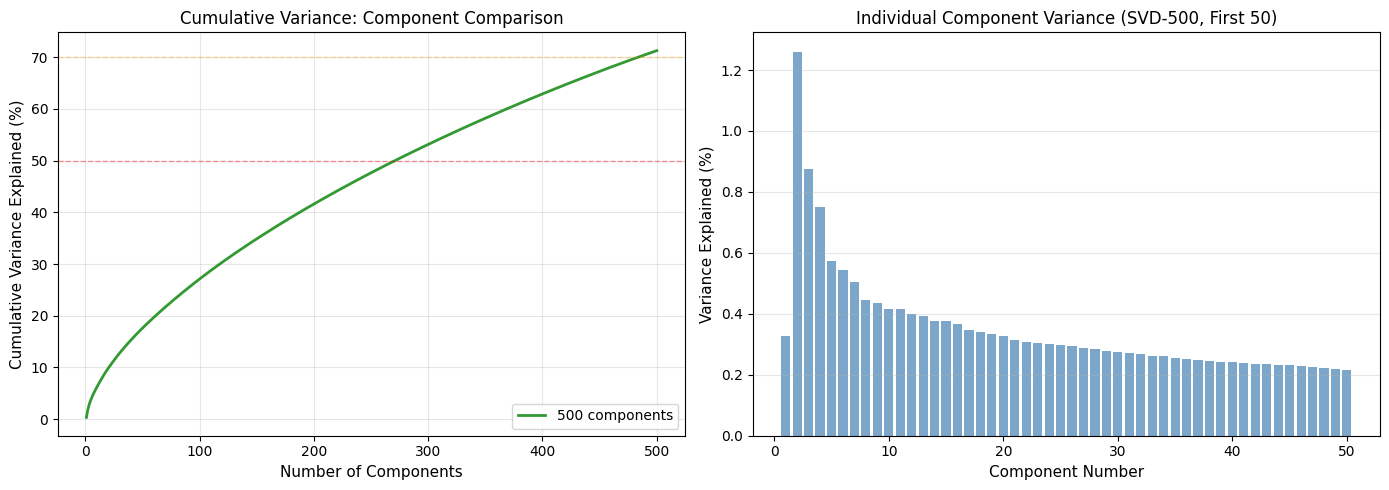

In [32]:
# create single comparison plot with both SVD configurations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# left: Cumulative variance comparison
ax1 = axes[0]

# check what we have
has_500 = os.path.exists('data/processed/svd_variance_info_500.pkl')

if has_500:
    info_500 = joblib.load('data/processed/svd_variance_info_500.pkl')
    ax1.plot(range(1, 501), info_500['cumulative_variance'] * 100, 
             'g-', linewidth=2, label='500 components', alpha=0.8)

ax1.axhline(y=50, color='r', linestyle='--', alpha=0.4, linewidth=1)
ax1.axhline(y=70, color='orange', linestyle='--', alpha=0.4, linewidth=1)
ax1.set_xlabel('Number of Components', fontsize=11)
ax1.set_ylabel('Cumulative Variance Explained (%)', fontsize=11)
ax1.set_title('Cumulative Variance: Component Comparison', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# right: Individual component variance (first 50 of SVD-500)
ax2 = axes[1]

if has_500:
    variance_500 = info_500['explained_variance_ratio'][:50] * 100
    ax2.bar(range(1, 51), variance_500, alpha=0.7, color='steelblue')
    ax2.set_xlabel('Component Number', fontsize=11)
    ax2.set_ylabel('Variance Explained (%)', fontsize=11)
    ax2.set_title('Individual Component Variance (SVD-500, First 50)', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# save plot
os.makedirs('results/figures', exist_ok=True)
plot_path = 'results/figures/svd_variance_comparison.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Variance comparison plot saved to: {plot_path}")

plt.show()

In [31]:
# verify all files created successfully

files_to_check = [
    f'data/processed/svd_reduced_{svd_components}d.pkl',
    f'data/processed/svd_model_{svd_components}.pkl',
    f'data/processed/svd_variance_info_{svd_components}.pkl',
    f'results/svd_{svd_components}_top_terms.txt',
    f'results/svd_variance_comparison.txt',
    f'results/figures/svd_variance_comparison.png'
]

print("\nVerifying outputs...")
print("-" * 60)

all_good = True
for file_path in files_to_check:
    if os.path.exists(file_path):
        if file_path.endswith('.pkl'):
            size_mb = os.path.getsize(file_path) / 1024**2
            print(f"✓ {file_path}")
            print(f"  Size: {size_mb:.1f} MB")
        else:
            size_kb = os.path.getsize(file_path) / 1024
            print(f"✓ {file_path}")
            print(f"  Size: {size_kb:.1f} KB")
    else:
        print(f"x Missing: {file_path}")
        all_good = False

print("-" * 60)

if all_good:
    print("\n✓✓✓ Success! ✓✓✓- All files created!")
    print(f"\nDimensionality reduction complete:")
    print(f"  {tfidf_matrix.shape[1]:,} TF-IDF features → {svd_components} SVD components")
    print(f"  Compression ratio: {tfidf_matrix.shape[1]/svd_components:.1f}x")
    print(f"  Variance preserved: {cumulative_variance[-1]*100:.1f}%")
    print(f"  Papers: {X_reduced.shape[0]:,}")
    print(f"  Memory: Dense matrix {X_reduced.nbytes/1024**3:.2f} GB")
    print(f"\nReady for clustering (Notebook 07)")
else:
    print("\nx Error - Some files missing!")


Verifying outputs...
------------------------------------------------------------
✓ data/processed/svd_reduced_500d.pkl
  Size: 4548.3 MB
✓ data/processed/svd_model_500.pkl
  Size: 1.9 MB
✓ data/processed/svd_variance_info_500.pkl
  Size: 0.0 MB
✓ results/svd_500_top_terms.txt
  Size: 2.0 KB
✓ results/svd_variance_comparison.txt
  Size: 1.2 KB
✓ results/figures/svd_variance_comparison.png
  Size: 83.5 KB
------------------------------------------------------------

✓✓✓ Success! ✓✓✓- All files created!

Dimensionality reduction complete:
  1,000 TF-IDF features → 500 SVD components
  Compression ratio: 2.0x
  Variance preserved: 71.3%
  Papers: 2,384,622
  Memory: Dense matrix 4.44 GB

Ready for clustering (Notebook 07)
